# Define the system  

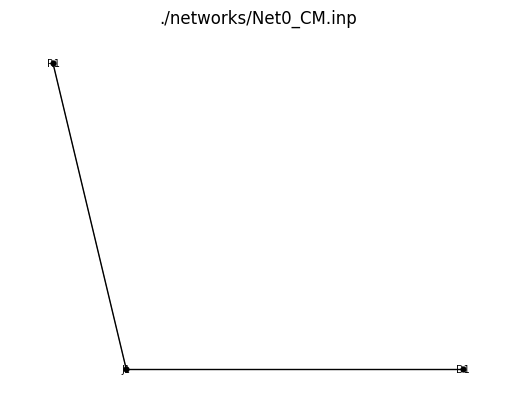

<Axes: title={'center': './networks/Net0_CM.inp'}>

In [597]:
import wntr
import wntr_quantum
import numpy as np
import matplotlib.pyplot as plt
# Create a water network model
inp_file = './networks/Net0_CM.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

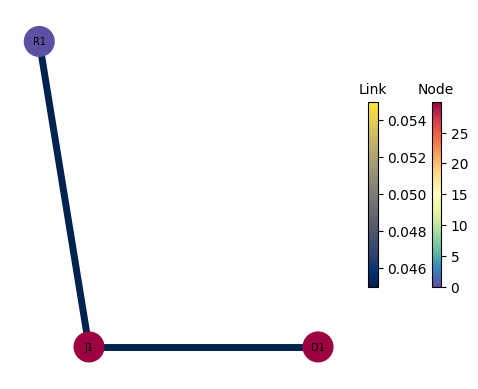

<Axes: >

In [598]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
flow_at_5hr = results.link['flowrate'].loc[0, :]
wntr.graphics.plot_network(wn, link_attribute=flow_at_5hr, 
                           node_attribute=pressure_at_5hr, 
                           node_size=500, 
                           link_width=5, 
                           node_labels=True,
                           link_cmap=plt.cm.cividis)

In [599]:
ref_pressure = results.node['pressure'].values[0][:2]
ref_rate = results.link['flowrate'].values[0]
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 0.05 ,  0.05 , 29.994, 29.988], dtype=float32)

## Run with the QUBO Polynomial Solver

In [600]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [601]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 5
step = (4./(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0, var_base_name="x")

nqbit = 5
step = (200/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 0.000000 => 200.000000 (res: 6.451613)
Flow Encoding : -4.000000 => -0.000000 | 0.000000 => 4.000000 (res: 0.129032)


Solve the system classically

In [602]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, bin_rep_sol, cvgd = net.classical_solutions()
ref_sol / ref_values

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1., 1., 1., 1.])

In [603]:
bin_rep_sol

[1, 1, [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]]

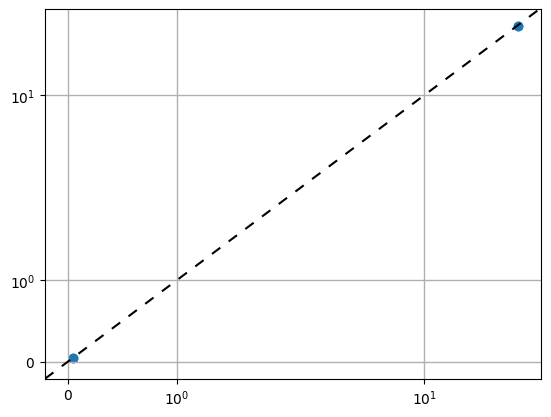

In [604]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values, encoded_ref_sol)
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
# plt.loglog()
plt.xscale('symlog')
plt.yscale('symlog')

In [605]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.matrices = net.initialize_matrices(model)

In [606]:
from wntr_quantum.sampler.simulated_annealing import SimulatedAnnealing
# from wntr_quantum.sampler.simulated_annealing_parallel import SimulatedAnnealing
sampler = SimulatedAnnealing()

In [607]:
from qubops.qubops_mixed_vars import QUBOPS_MIXED
import sparse
net.qubo = QUBOPS_MIXED(net.mixed_solution_vector, {"sampler": sampler})
matrices = tuple(sparse.COO(m) for m in net.matrices)
net.qubo.qubo_dict = net.qubo.create_bqm(matrices, strength=0)

In [608]:
from wntr_quantum.sampler.step.full_random import RandomStep
from wntr_quantum.sampler.step.full_random import IncrementalStep
from wntr_quantum.sampler.step.full_random import ParallelIncrementalStep 

var_names = sorted(net.qubo.qubo_dict.variables)
net.qubo.create_variables_mapping()
# mystep = RandomStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables)
mystep = IncrementalStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables, step_size=1)
# mystep = ParallelIncrementalStep(var_names, net.qubo.mapped_variables, net.qubo.index_variables, step_size=100)

# generate init sample

In [609]:
from wntr_quantum.sampler.simulated_annealing import generate_random_valid_sample
x = generate_random_valid_sample(net.qubo)
x0 = list(x.values())

In [610]:
from wntr_quantum.sampler.simulated_annealing import modify_solution_sample
x = modify_solution_sample(net, bin_rep_sol, modify=['flows', 'heads'])
x0 = list(x.values())

In [611]:
eref = net.qubo.energy_binary_rep(bin_rep_sol)

In [612]:
num_sweeps = 2000
Tinit = 1E3
Tfinal = 1E-1
Tschedule = np.linspace(Tinit, Tfinal, num_sweeps)
Tschedule = np.append(Tschedule, Tfinal*np.ones(200))

In [613]:
# mystep.optimize_values = np.arange(2, 6)
res = sampler.sample(net.qubo.qubo_dict, x0=x0, Tschedule=Tschedule, take_step=mystep, save_traj=True)
mystep.verify_quadratic_constraints(res.res)

  3%|▎         | 62/2200 [00:00<00:03, 619.50it/s]

100%|██████████| 2200/2200 [00:02<00:00, 928.87it/s]


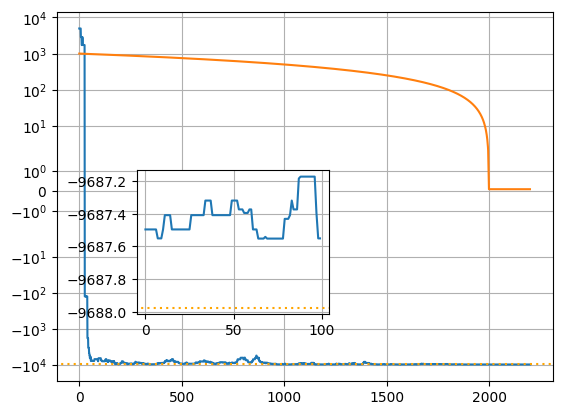

In [614]:
import matplotlib.pyplot as plt
eplt = res.energies

fig, ax1 = plt.subplots()

left, bottom, width, height = [0.25, 0.25, 0.3, 0.3]

ax1.plot(eplt)
ax1.plot(Tschedule)
ax1.axline((0, eref[0]), slope=0, color="orange", linestyle=(1, (1, 2)))
# plt.ylim([-1E5, -1E4])
# plt.xlim([9000,11000])
ax1.grid()
ax1.set_yscale('symlog')

ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(eplt[-100:])
ax2.grid()
ax2.axline((0, eref[0]), slope=0, color="orange", linestyle=(1, (1, 2)))
# ax2.set_yscale('symlog')

In [615]:
idx_min = np.array([e[0] for e in res.energies]).argmin()
sol = res.trajectory[idx_min]
sol = net.qubo.decode_solution(np.array(sol))
sol = net.combine_flow_values(sol)
sol = net.convert_solution_to_si(sol)

Text(0.5, 1.0, 'Pressure')

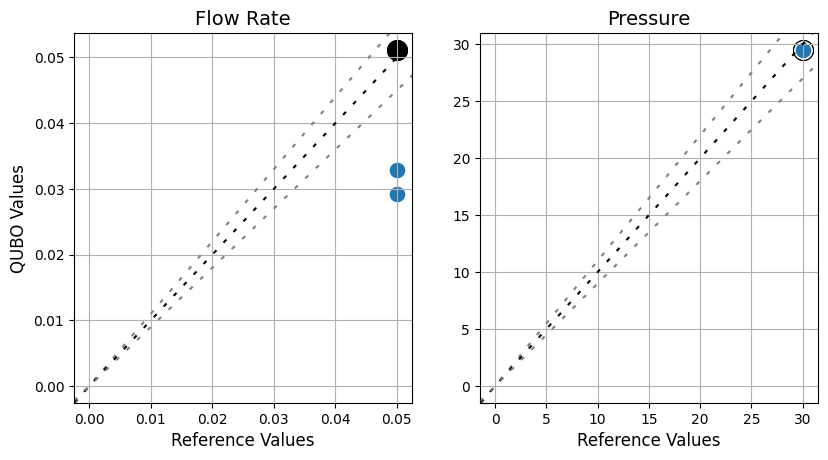

In [616]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = plt.figaspect(0.5))
ax1 = fig.add_subplot(121)

ax1.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax1.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))
ax1.grid()

ax1.scatter(ref_values[:2], encoded_ref_sol[:2], c='black', s=200, label='Best solution')
ax1.scatter(ref_values[:2], sol[:2], s=150, lw=1, edgecolors='w', label='Sampled solution')


ax1.set_xlabel('Reference Values', fontsize=12)
ax1.set_ylabel('QUBO Values', fontsize=12)
ax1.set_title('Flow Rate', fontsize=14)

ax2 = fig.add_subplot(122)

ax2.axline((0, 0.0), slope=1.10, color="grey", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
ax2.axline((0, 0.0), slope=0.90, color="grey", linestyle=(0, (2, 5)))


ax2.scatter(ref_values[2:], encoded_ref_sol[2:], c='black', s=200, label='Best solution')
ax2.scatter(ref_values[2:], sol[2:], s=150, lw=1, edgecolors='w', label='Sampled solution')
ax2.grid()

# ax2.set_xlim([160,210])
# ax2.set_ylim([160,210])
ax2.set_xlabel('Reference Values', fontsize=12)
ax2.set_title('Pressure', fontsize=14)

## Explore the solution space

0it [00:00, ?it/s]

/tmp/ipykernel_7835/3452845714.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
32it [00:00, 75.13it/s]


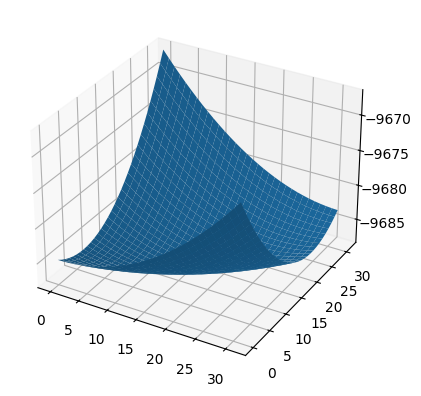

In [617]:
import itertools
from tqdm import tqdm

nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit
energies = np.zeros((2**nqbit, 2**nqbit))
i2 = 0
for data2 in tqdm(itertools.product([0, 1], repeat=nqbit)):
    i3 = 0
    for data3 in itertools.product([0, 1], repeat=nqbit):
        # print(list(data))
        mod_bin_rep_sol = deepcopy(bin_rep_sol)
        mod_bin_rep_sol[2] = list(data2)[::-1]
        mod_bin_rep_sol[3] = list(data3)[::-1]
        # x = net.qubo.extend_binary_representation(flatten_list(mod_bin_rep_sol))
        # x0 = list(x.values())
        energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
        i3+=1
    i2+=1

x, y = np.arange(2**nqbit), np.arange(2**nqbit)
x,y = np.meshgrid(x,y)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(x,y,energies)

0it [00:00, ?it/s]/tmp/ipykernel_7835/685105249.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
32it [00:00, 72.16it/s]


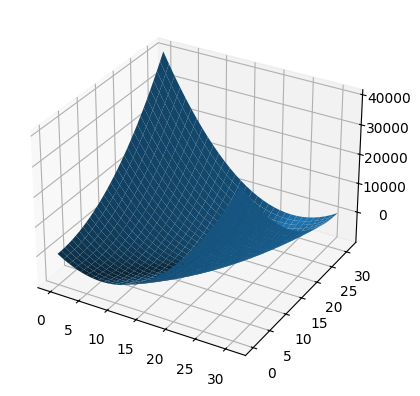

In [618]:
import itertools
from tqdm import tqdm
from copy import deepcopy

nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit
energies = np.zeros((2**nqbit, 2**nqbit))
i2 = 0
for data2 in tqdm(itertools.product([0, 1], repeat=nqbit)):
    i3 = 0
    for data3 in itertools.product([0, 1], repeat=nqbit):
        # print(list(data))
        mod_bin_rep_sol = deepcopy(bin_rep_sol)
        mod_bin_rep_sol[4] = list(data2)[::-1]
        mod_bin_rep_sol[5] = list(data3)[::-1]
        # x = net.qubo.extend_binary_representation(flatten_list(mod_bin_rep_sol))
        # x0 = list(x.values())
        energies[i3,i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
        i3+=1
    i2+=1

x, y = np.arange(2**nqbit), np.arange(2**nqbit)
x,y = np.meshgrid(x,y)
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(x,y,energies)
# plt.show()

0it [00:00, ?it/s]/tmp/ipykernel_7835/3224148935.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  energies[i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)
32it [00:00, 1909.11it/s]


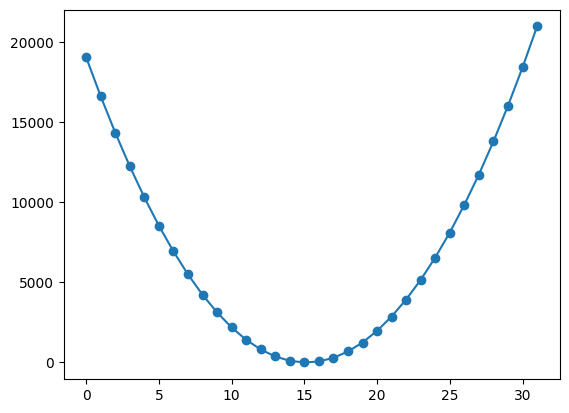

In [619]:
import itertools
from tqdm import tqdm

nqbit = net.mixed_solution_vector.encoded_reals[2].nqbit
energies = np.zeros(2**nqbit)
i2 = 0
for data2 in tqdm(itertools.product([0, 1], repeat=nqbit)):

    mod_bin_rep_sol = deepcopy(bin_rep_sol)
    mod_bin_rep_sol[4] = list(data2)[::-1]
    # mod_bin_rep_sol[3] = list(data2)[::-1]
    energies[i2] = net.qubo.energy_binary_rep(mod_bin_rep_sol)

    i2+=1
plt.plot(energies-eref, 'o-')

In [655]:
def flatten_list(lst):
    out = []
    for elmt in lst:
        if not isinstance(elmt, list):
            out += [elmt]
        else:
            out += elmt
    return out

bin_rep_flat = flatten_list(bin_rep_sol)
xt_bin_rep_flat = net.qubo.extend_binary_representation(bin_rep_flat)
xt_bin_rep_flat.values()


dict_values([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [657]:
xt_bin_rep_flat_new = mystep(list(xt_bin_rep_flat.values()))
x_new = []
for k,v in mystep.index_values.items():
    if len(v) == 1:
        x_new.append(xt_bin_rep_flat_new[v[0]])
    else:
        tmp = []
        for idx in v:
            tmp.append(xt_bin_rep_flat_new[idx])
        x_new.append(tmp)
print(bin_rep_sol)
print(x_new)

[1, 1, [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]]
[1, 0, [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 0]]


In [622]:
p = net.qubo.create_polynom(np.array(net.qubo.x))
pp = p.T @ p
pp[0].expand().as_ordered_terms()

[4.06595691246814e-8*x_001_001**2*x_003_001**4,
 3.25276552997451e-7*x_001_001**2*x_003_001**3*x_003_002,
 6.50553105994902e-7*x_001_001**2*x_003_001**3*x_003_003,
 1.3011062119898e-6*x_001_001**2*x_003_001**3*x_003_004,
 2.60221242397961e-6*x_001_001**2*x_003_001**3*x_003_005,
 9.75829658992353e-7*x_001_001**2*x_003_001**2*x_003_002**2,
 3.90331863596941e-6*x_001_001**2*x_003_001**2*x_003_002*x_003_003,
 7.80663727193883e-6*x_001_001**2*x_003_001**2*x_003_002*x_003_004,
 1.56132745438777e-5*x_001_001**2*x_003_001**2*x_003_002*x_003_005,
 3.90331863596941e-6*x_001_001**2*x_003_001**2*x_003_003**2,
 1.56132745438777e-5*x_001_001**2*x_003_001**2*x_003_003*x_003_004,
 3.12265490877553e-5*x_001_001**2*x_003_001**2*x_003_003*x_003_005,
 1.56132745438777e-5*x_001_001**2*x_003_001**2*x_003_004**2,
 6.24530981755106e-5*x_001_001**2*x_003_001**2*x_003_004*x_003_005,
 6.24530981755106e-5*x_001_001**2*x_003_001**2*x_003_005**2,
 0.0665972944849115*x_001_001**2*x_003_001**2,
 1.3011062119898e-6*x_

In [624]:
for k, v in net.qubo.qubo_dict.linear.items():
    if k.startswith('x_005'):
        print(k,v)

x_005_001 -1186.7559218989402
x_005_002 -2207.018607585602
x_005_003 -3748.0642703220883
x_005_004 -4832.236761247715
x_005_005 991.0935950904168


In [625]:
for k, v in net.qubo.qubo_dict.quadratic.items():
    # if k.startswith('x_005'):
    print(k,v)

('x_002_001', 'x_004_003') -3.6453849508657123
('x_004_003*x_002_001', 'x_004_003') 0.0
('x_004_003*x_002_001', 'x_002_001') 0.0
('x_004_004', 'x_004_003') 2.1312799651123044
('x_004_004', 'x_002_001') -7.290769901731425
('x_004_004', 'x_004_003*x_002_001') -1.7763568394002505e-15
('x_004_004*x_002_001', 'x_002_001') 0.0
('x_004_004*x_002_001', 'x_004_004') 0.0
('x_003_003', 'x_004_003') -0.5327783558792923
('x_003_003', 'x_004_003*x_002_001') 1.0655567117585847
('x_003_003', 'x_004_004') -1.0655567117585847
('x_003_003', 'x_004_004*x_002_001') 2.1311134235171694
('x_003_003', 'x_001_001') -0.6350934832009412
('x_001_001*x_003_003', 'x_004_003') 1.0655567117585847
('x_001_001*x_003_003', 'x_004_003*x_002_001') -2.1311134235171694
('x_001_001*x_003_003', 'x_004_004') 2.1311134235171694
('x_001_001*x_003_003', 'x_004_004*x_002_001') -4.262226847034339
('x_001_001*x_003_003', 'x_001_001') 0.0
('x_001_001*x_003_003', 'x_003_003') 0.0
('x_004_001', 'x_004_003') 0.2663929186200057
('x_004_00

# Embed the problem

In [626]:
import dwave_networkx as dnx
from minorminer import find_embedding
from dwave.embedding import embed_qubo, majority_vote, chain_break_frequency

In [627]:
net.qubo.qubo_dict.to_qubo()[0]

{('x_002_001', 'x_004_003'): -3.6453849508657123,
 ('x_004_003*x_002_001', 'x_004_003'): 0.0,
 ('x_004_003*x_002_001', 'x_002_001'): 0.0,
 ('x_004_004', 'x_004_003'): 2.1312799651123044,
 ('x_004_004', 'x_002_001'): -7.290769901731425,
 ('x_004_004', 'x_004_003*x_002_001'): -1.7763568394002505e-15,
 ('x_004_004*x_002_001', 'x_002_001'): 0.0,
 ('x_004_004*x_002_001', 'x_004_004'): 0.0,
 ('x_003_003', 'x_004_003'): -0.5327783558792923,
 ('x_003_003', 'x_004_003*x_002_001'): 1.0655567117585847,
 ('x_003_003', 'x_004_004'): -1.0655567117585847,
 ('x_003_003', 'x_004_004*x_002_001'): 2.1311134235171694,
 ('x_003_003', 'x_001_001'): -0.6350934832009412,
 ('x_001_001*x_003_003', 'x_004_003'): 1.0655567117585847,
 ('x_001_001*x_003_003', 'x_004_003*x_002_001'): -2.1311134235171694,
 ('x_001_001*x_003_003', 'x_004_004'): 2.1311134235171694,
 ('x_001_001*x_003_003', 'x_004_004*x_002_001'): -4.262226847034339,
 ('x_001_001*x_003_003', 'x_001_001'): 0.0,
 ('x_001_001*x_003_003', 'x_003_003'): 0.0,

In [628]:
# target_graph = dnx.pegasus_graph(6)
# embedding = find_embedding(net.qubo.qubo_dict.to_qubo()[0], target_graph)

In [629]:
# embedding

In [630]:
# dnx.draw_pegasus(dnx.pegasus_graph(6),  node_size=2, width=0.1)

In [631]:
# dnx.draw_pegasus_embedding(target_graph, embedding, node_size=10, width=0.25)